## Preamble

In [1]:
from pydci.examples.monomial import monomial
from pydci.log import enable_log
from pydci import DCIProblem
from scipy.stats.distributions import norm
import numpy as np
import importlib
import matplotlib.pyplot as plt

__author__ = "Carlos del-Castillo-Negrete"
__copyright__ = "Carlos del-Castillo-Negrete"
__license__ = "mit"

seed = 123456

_ = enable_log()

[04/06/23 15:19:57] INFO     Logger initialized                                                           ]8;id=124692;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=599114;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/log.py#35\35]8;;\

<a id='Title'></a>
# <center> Data-Consistent Inversion Class
_____

<center>
    Notebook by:
    <br>
    Carlos del-Castillo-Negrete (<font color='blue'>cdelcastillo21@gmail.com</font>)
</center>

The purpose of this notebook is to demonstrate usage of the `DCIProblem` class and plotting capabilities.

<a id='Title'></a>
## Data-Consistent Update Formula: 

$\Large \pi_{up}(\lambda) = \pi_{in}(\lambda)\frac{\pi_{ob}(Q(\lambda))}{\pi_{pred}(Q(\lambda))}$


Note:

* $\pi_{in}$ represents initial descripton of aleatoric, or irreducible, uncertainty on $\Lambda$.

* Data-Consistent comes from Disintegration theorem and Bayes rule [ref].


## Example 1 - Low Dimensional Example
---

We start with a simple QoI map over a one-dimensional parameter space:
   
   $$ \Large \Lambda = [-1, 1] \in \mathbb{R} $$  
   
   $$ \Large Q(\lambda) = \lambda^5 \rightarrow \mathcal{D} = [-1, 1] $$

We assume:

   $\pi_{in} \sim \mathcal{U}([-1, 1])$
  
   $\pi_{ob} \sim \mathcal{N}(0.25,0.1^2)$

### Data

We take $N$ samples from an initial uniform distribution over the input parameter space. These samples will be pushed forward through our QoI map to constrcut the predicted density $\pi_{pred}$:

In [2]:
# Number of samples to use, and assumed observed normal distribution parameters
np.random.seed(seed)
p, num_samples, mu, sigma, domain = 5, int(1e3), 0.25, 0.1, [-1, 1]
lam, q_lam, data = monomial(
    p=p,
    num_samples=num_samples,
    domain=domain,
    mu=mu,
    sigma=sigma,
    N=1)
obs_dist = norm(loc=np.mean(data), scale=sigma)
lam.shape, q_lam.shape, data.shape

((1000, 1), (1000, 1), (1,))

In [4]:
# Construct density problem object using lambda samples and QoI Values
# Note by default DensityProblem class assumes uniform distribution over domain if nothing specified
# The predicted distribution will be determined from a Gaussian Kernel Density Estimate over predicted values
# Have to set observed distribution -> assuming known sample mean, 0.25, and std dev, 0.1, from observed data.
importlib.reload(DCIProblem)
d_prob = DCIProblem.DCIProblem(lam, q_lam, obs_dist)
d_prob.solve()

[04/06/23 15:20:09] INFO     Adding q_lam of size 1 to dataframe                                       ]8;id=677144;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/utils.py\utils.py]8;;\:]8;id=83744;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/utils.py#147\147]8;;\

                    INFO     Adding lam of size 1 to dataframe                                         ]8;id=709563;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/utils.py\utils.py]8;;\:]8;id=68316;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/utils.py#147\147]8;;\

In [6]:
d_prob.state           # State stores all info on the DCI problem as solved

,weight,pi_in,pi_pr,pi_obs,ratio,pi_up,lam_0,q_lam_0
0,1.0,0.453013,0.406244,0.000038,0.000092,0.000042,-0.746060,-0.231137
1,1.0,0.370229,0.173494,0.000108,0.000622,0.000230,0.933436,0.708634
2,1.0,0.535527,3.181646,0.090365,0.028402,0.015210,-0.479048,-0.025229
3,1.0,0.454461,0.247348,3.197684,12.927849,5.875209,0.794473,0.316516
4,1.0,0.514298,3.325140,0.171333,0.051526,0.026500,-0.246501,-0.000910
...,...,...,...,...,...,...,...,...
995,1.0,0.488401,3.264702,0.252562,0.077361,0.037783,0.432104,0.015064
996,1.0,0.499770,3.306908,0.212984,0.064406,0.032188,0.379948,0.007918
997,1.0,0.541642,3.287667,0.125151,0.038067,0.020619,-0.420394,-0.013130
998,1.0,0.541358,3.277962,0.120212,0.036673,0.019853,-0.429739,-0.014656


In [7]:
d_prob.result

,e_r,kl
0,0.789373,2.120273


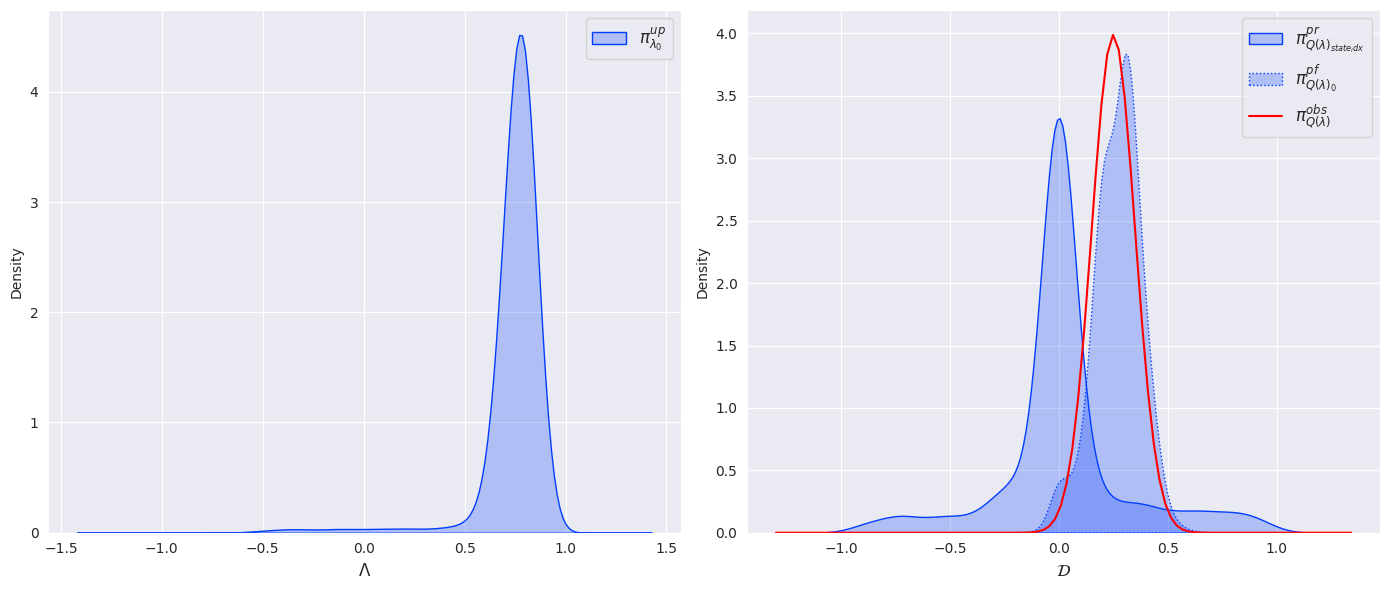

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
_, _ = d_prob.plot_param_state(ax=axs[0]), d_prob.plot_obs_state(ax=axs[1])